In [2]:
pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [3]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
import numpy as np

In [4]:
import numpy as np

In [5]:
# This detect if cuda is available for GPU training otherwise it will use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

print(imsize)
# scale imported image
# transform it into a torch tensor
loader = transforms.Compose([transforms.Resize(imsize),  transforms.ToTensor()])  

128


In [6]:
# Helper function
def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [8]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.


In [9]:
from PIL import Image

def resize_images(image1_path, image2_path, output_size=(300, 300)):
    # Open the images
    image1 = Image.open(image1_path)
    image2 = Image.open(image2_path)

    # Resize the images
    image1_resized = image1.resize(output_size)
    image2_resized = image2.resize(output_size)

    # Save the resized images
    image1_resized.save("resized_image1.jpg")
    image2_resized.save("resized_image2.jpg")

# Replace 'path_to_image1.jpg' and 'path_to_image2.jpg' with the actual paths of your images
resize_images('love_1.jpg', 'dancing.jpg')

In [12]:
# Helper function to show the tensor as a PIL image
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

In [11]:
# Loading of images
image_directory = "images/"
style_img = image_loader("resized_image1.jpg")
content_img = image_loader( "resized_image2.jpg")

assert style_img.size() == content_img.size(), "we need to import style and content images of the same size"

unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

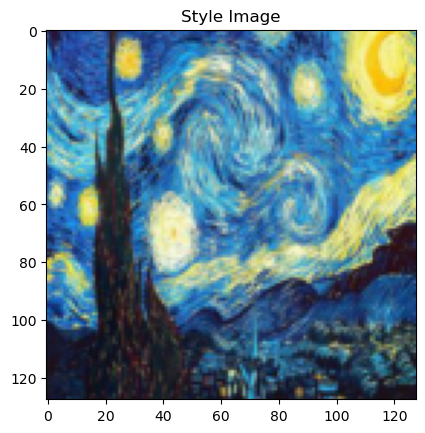

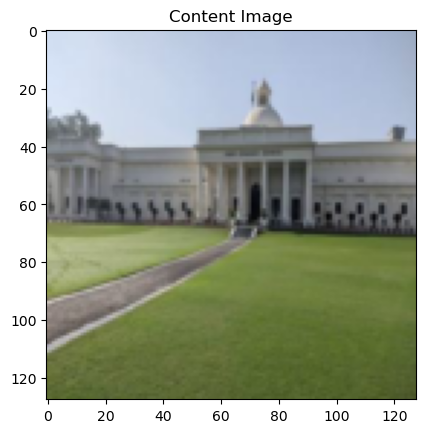

In [13]:
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [14]:
# Custom content loss 
# \]|c>:/']'0 Vavi's code
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

# This is for the style loss
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)


In [16]:
# Same structure as the content loss
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [17]:
# Importing the VGG 19 model like in the paper (here we set it to evaluation mode)
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# VGG network are normalized with special values for the mean and std
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

C:\Users\91966\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\91966\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\91966/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [18]:
# create a module to normalize input image so we can easily put it in a nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std


In [19]:
# Here we insert the loss layer at the right spot

# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [20]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

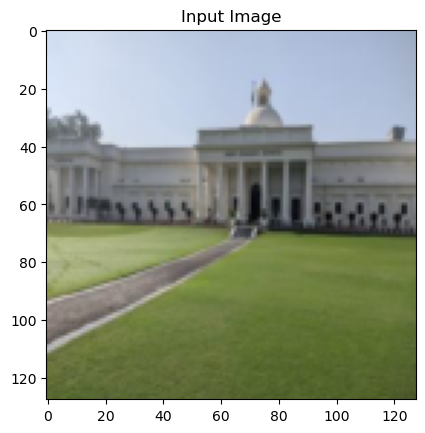

In [21]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
#input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [22]:
# This type of optimizer was prefered by the author of the paper
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

# This will run the neural style transfer
# It will create image that goes above 1 or below 0, however it will be normalized
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction to have the tensors between 0 and 1
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..


C:\Users\91966\AppData\Local\Temp\ipykernel_13996\4149220151.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
C:\Users\91966\AppData\Local\Temp\ipykernel_13996\4149220151.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 438.707489 Content Loss: 51.302673

run [100]:
Style Loss : 101.633095 Content Loss: 50.258644

run [150]:
Style Loss : 46.315544 Content Loss: 48.224991

run [200]:
Style Loss : 29.414793 Content Loss: 46.093552

run [250]:
Style Loss : 21.332533 Content Loss: 43.971123

run [300]:
Style Loss : 16.409313 Content Loss: 42.092892

run [350]:
Style Loss : 13.180009 Content Loss: 40.450668

run [400]:
Style Loss : 10.816937 Content Loss: 39.094826

run [450]:
Style Loss : 9.242030 Content Loss: 38.013351

run [500]:
Style Loss : 8.073812 Content Loss: 37.098209

run [550]:
Style Loss : 7.211109 Content Loss: 36.409260

run [600]:
Style Loss : 6.578442 Content Loss: 35.725029

run [650]:
Style Loss : 6.110812 Content Loss: 35.087952

run [700]:
Style Loss : 5.537136 Content Loss: 34.627144

run [750]:
Style Loss : 5.203598 Content Loss: 34.155876

run [800]:
Style Loss : 4.893793 Content Loss: 33.759216

run [850]:
Style Loss : 4.702921 Content Loss: 33.

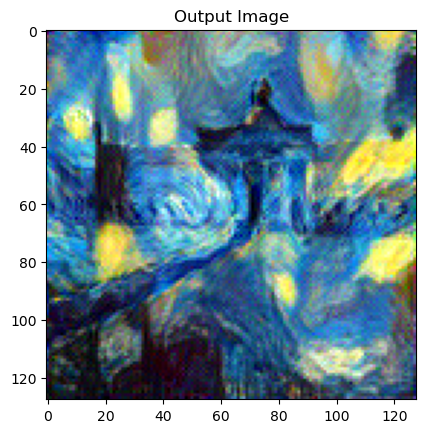

In [23]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=3000)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

# TODO: We should have the output showing be in the run_style_transfer code 
# since we can tell it to increase the number of steps if the image is not sharp enough

In [7]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy


# This detect if cuda is available for GPU training otherwise it will use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

print(imsize)
# scale imported image
# transform it into a torch tensor
loader = transforms.Compose([transforms.Resize(imsize),  transforms.ToTensor()])  

# Helper function
def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


# Loading of images
image_directory = "images/"
style_img = image_loader("love_1.jpg")
content_img = image_loader( "dancing.jpg")

assert style_img.size() == content_img.size(), "we need to import style and content images of the same size"


unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

# Helper function to show the tensor as a PIL image
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated



plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')
# Custom content loss 
# \]|c>:/']'0 Vavi's code
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

# This is for the style loss
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

# Same structure as the content loss
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

# Importing the VGG 19 model like in the paper (here we set it to evaluation mode)
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# VGG network are normalized with special values for the mean and std
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

# Here we insert the loss layer at the right spot

# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
#input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

# This type of optimizer was prefered by the author of the paper
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

# This will run the neural style transfer
# It will create image that goes above 1 or below 0, however it will be normalized
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction to have the tensors between 0 and 1
    input_img.data.clamp_(0, 1)

    return input_img

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=3000)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

# TODO: We should have the output showing be in the run_style_transfer code 
# since we can tell it to increase the number of steps if the image is not sharp enough

128


AssertionError: we need to import style and content images of the same size